In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Analyse de la concentration de CO2 dans l'atmosphère depuis 1958
# 1. Chargement des données

Récupérons directement les données sur le site [officiel](https://scrippsco2.ucsd.edu/).

In [60]:
# Step 0: Load the raw data without the readme info.
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"
df = pd.read_csv(data_url, skiprows=60).reset_index()

# Step 1: Concatenate the first three rows to form the header
header = df.iloc[:3].astype(str).agg(' '.join).str.strip().tolist()

# Step 2: Create a new DataFrame with the correct header
df.columns = header
df.columns = [" ".join(col.split()) for col in df.columns]

# Step 3: Drop the first three rows (now redundant)
df = df.iloc[3:, :-1].reset_index(drop=True).apply(pd.to_numeric)
df['Date'] = df.apply(lambda row: datetime.date(int(row.Yr),int(row.Mn),1), axis=1)

# Display the updated DataFrame
df.head(15)


Yr  Mn  Date Excel        Date  CO2 [ppm]  seasonally adjusted [ppm]  \
0   1958   1       21200  1958-01-01     -99.99                     -99.99   
1   1958   2       21231  1958-02-01     -99.99                     -99.99   
2   1958   3       21259  1958-03-01     315.71                     314.43   
3   1958   4       21290  1958-04-01     317.45                     315.15   
4   1958   5       21320  1958-05-01     317.51                     314.69   
5   1958   6       21351  1958-06-01     -99.99                     -99.99   
6   1958   7       21381  1958-07-01     315.87                     315.20   
7   1958   8       21412  1958-08-01     314.93                     316.23   
8   1958   9       21443  1958-09-01     313.21                     316.12   
9   1958  10       21473  1958-10-01     -99.99                     -99.99   
10  1958  11       21504  1958-11-01     313.33                     315.21   
11  1958  12       21534  1958-12-01     314.67                     315.43   
12  1959   1       21565  1959-01-01     315.58                     315.52   
13  1959   2       21596  1959-02-01     316.49                     315.84   
14  1959   3       21624  1959-03-01     316.65                     315.37   

    fit [ppm]  seasonally adjusted fit [ppm]  CO2 filled [ppm]  \
0      -99.99                         -99.99            -99.99   
1      -99.99                         -99.99            -99.99   
2      316.20                         314.90            315.71   
3      317.30                         314.98            317.45   
4      317.88                         315.06            317.51   
5      317.27                         315.14            317.27   
6      315.85                         315.21            315.87   
7      313.95                         315.28            314.93   
8      312.42                         315.35            313.21   
9      312.41                         315.40            312.41   
10     313.60                         315.46            313.33   
11     314.76                         315.51            314.67   
12     315.63                         315.57            315.58   
13     316.29                         315.63            316.49   
14     316.99                         315.69            316.65   

    seasonally adjusted filled [ppm]  
0                             -99.99  
1                             -99.99  
2                             314.43  
3                             315.15  
4                             314.69  
5                             315.14  
6                             315.20  
7                             316.23  
8                             316.12  
9                             315.40  
10                            315.21  
11                            315.43  
12                            315.52  
13                            315.84  
14                            315.37

## 2. Analyse des données manquantes

Affichage du nombre de données manquantes par colonne. Les données manquantes sont remplacées par la valeur -99.99.

In [62]:
(df==-99.99).sum()

Yr                                   0
Mn                                   0
Date Excel                           0
Date                                 0
CO2 [ppm]                           17
seasonally adjusted [ppm]           17
fit [ppm]                           13
seasonally adjusted fit [ppm]       13
CO2 filled [ppm]                    12
seasonally adjusted filled [ppm]    12
dtype: int64

Keep only the non missing data.

In [63]:
df = df.loc[(df!=-99.99).all(1)].reset_index(drop=True)

Nous pouvons voir si tous les mois sont représentés de la même façon:

In [78]:
df.groupby("Mn").count()["Yr"]

Mn
1     67
2     65
3     66
4     66
5     67
6     66
7     67
8     67
9     67
10    66
11    67
12    67
Name: Yr, dtype: int64

## 3. Caractérisation des phénomènes périodiques sous-jacents

Affichons les tendances annuelles, qui sont relativements courtes, comparativement à la tendance globale.

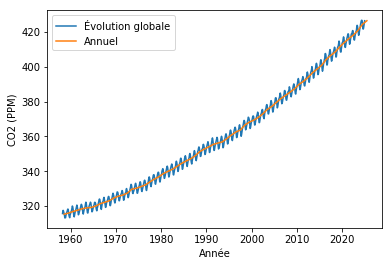

In [124]:
CO2 = df.iloc[:,4].values
dates = df.loc[:,'Date'].values
df_yearly_mean = df.groupby("Yr").mean()
CO2_yearly = df_yearly_mean.loc[:,"CO2 [ppm]"].values
dates_yearly_f = df_yearly_mean.index.values
dates_yearly = [datetime.date(int(d), 7, 1) for d in dates_yearly_f]

plt.plot(dates, CO2, label="Évolution globale")
plt.plot(dates_yearly, CO2_yearly, label="Annuel")
plt.ylabel("CO2 (PPM)")
plt.xlabel("Année")
plt.legend()
plt.show()

Affichons maintenant la tendance sur une année. Moyennons pour chaque mois sur toutes les années.

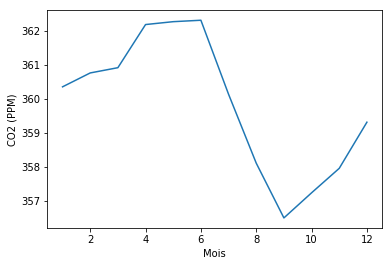

In [125]:
df_mn = df.groupby('Mn').mean()
CO2 = df_mn.iloc[:,4].values
months = df_mn.index.values

plt.plot(months, CO2)
plt.ylabel("CO2 (PPM)")
plt.xlabel("Mois")
plt.show()

On observe une tendance annuelle dû aux saisons. On a également observé une tendance globale à la hausse.

## 4. Prédiction pour les années futures

Nous proposons une régression linéaire simple pour estimer les valeurs pour les prochaines années.

In [126]:
pente = ((CO2_yearly-CO2_yearly.mean())*(dates_yearly_f-dates_yearly_f.mean())).sum()/((dates_yearly_f-dates_yearly_f.mean())**2).sum()
origine = CO2_yearly.mean() - pente * dates_yearly_f.mean()

In [129]:
origine

-2930.5194959134415

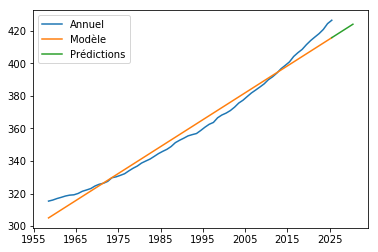

In [137]:
plt.plot(dates_yearly, CO2_yearly, label="Annuel")
plt.plot(dates_yearly, pente*dates_yearly_f+origine, label="Modèle")

dates_yearly_pred_f = np.arange(2025,2031)
dates_yearly_pred = [datetime.date(int(d), 7, 1) for d in dates_yearly_pred_f]
plt.plot(dates_yearly_pred, pente*dates_yearly_pred_f+origine, label="Prédictions")

plt.legend()